In [ ]:
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context='talk', style='ticks')
%matplotlib inline

with open('kendrick lamar.txt', 'r', encoding='ascii', errors='ignore') as file:
    lines = file.readlines()


In [ ]:

titles = []
lyrics = []

for line in lines:
    if 'Lyrics' in line:
        title, lyric = line.split('Lyrics', 1)
        titles.append(title.strip())
        lyrics.append(lyric.strip())
    else:
        lyrics[-1] += ' ' + line.strip()

df = pd.DataFrame({'title': titles, 'lyrics': lyrics})
df['lyrics'][0]
df['#characters'] = df.lyrics.str.len()
df['#words'] = df.lyrics.str.split().str.len()
df['#uniq_words'] = df.lyrics.apply(lambda x: len(set(x.split())))
df['lexical_density'] = df['#uniq_words'] / df['#words']

In [ ]:
df.head()

,title,lyrics,#characters,#words,#uniq_words,lexical_density
0,Kendrick Lamar Humble,Nobody pray for meIt been that day for meWay ...,1788,335,195,0.582090
1,Kendrick Lamar Maad City,If Pirus and Crips all got alongThey'd probab...,2109,371,253,0.681941
2,Kendrick Lamar Swimming Pools Drank,"Pour up , head shot Sit down , stand up Pass ...",1594,304,176,0.578947
3,Kendrick Lamar Dna,"I got, I got, I got, I gotLoyalty, got royalt...",3497,583,329,0.564322
4,Kendrick Lamar Money Trees,"Uh, me and my niggas tryna get it, ya bish Hi...",1908,362,216,0.596685


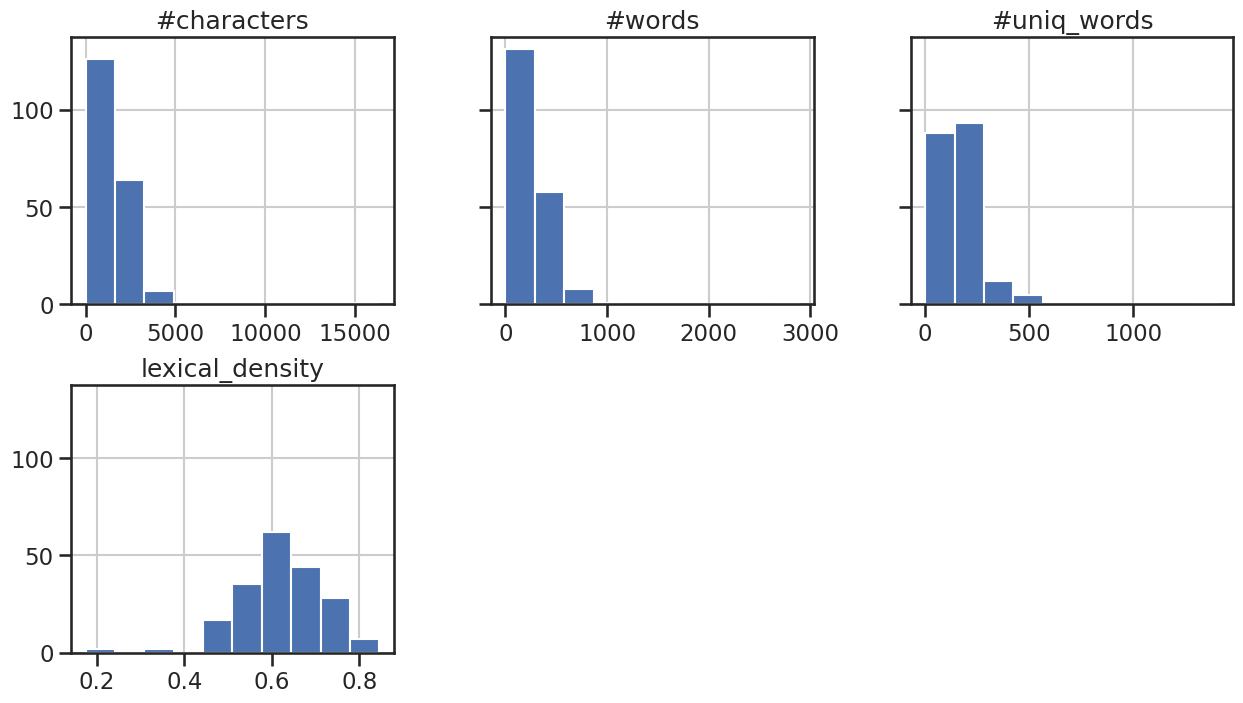

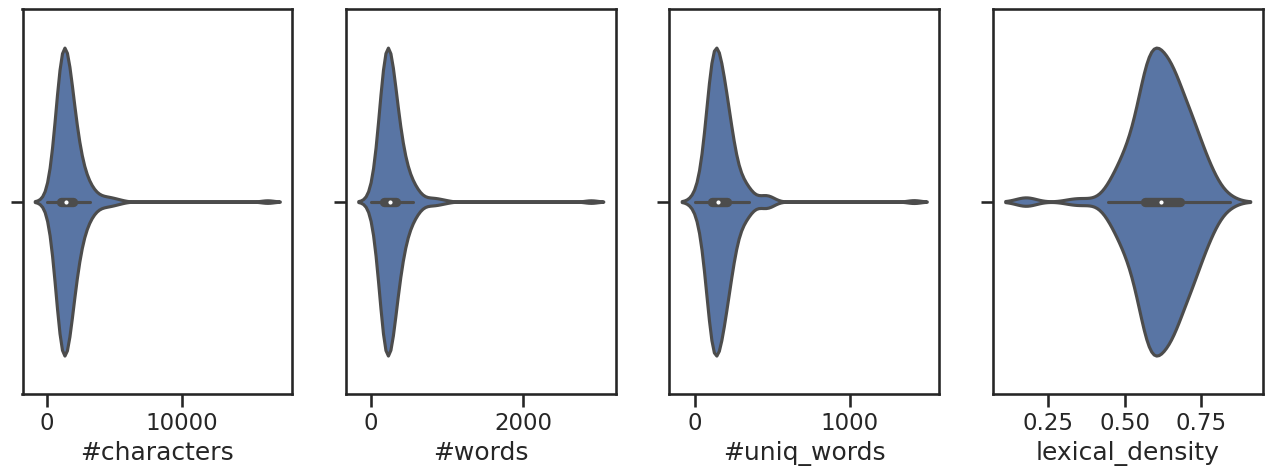

In [ ]:

df.hist(sharey=True, layout=(2, 3), figsize=(15, 8));

cols_metrics = df.select_dtypes(include=[np.number]).columns
fig, axs = plt.subplots(ncols=len(cols_metrics), figsize=(16, 5))
for i, c in enumerate(cols_metrics):
    sns.violinplot(x=df[c], ax=axs[i], sharex=True)
    

<Axes: >

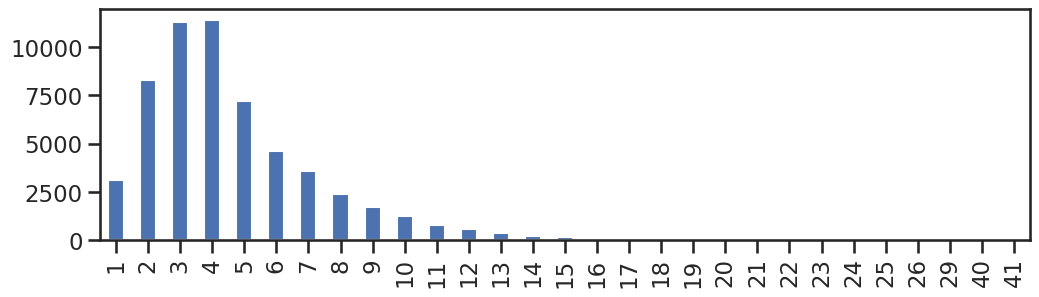

In [ ]:
    
# Word length distribution
pd.Series(len(x) for x in ' '.join(df.lyrics).split()).value_counts().sort_index().plot(kind='bar', figsize=(12, 3))


<Axes: >

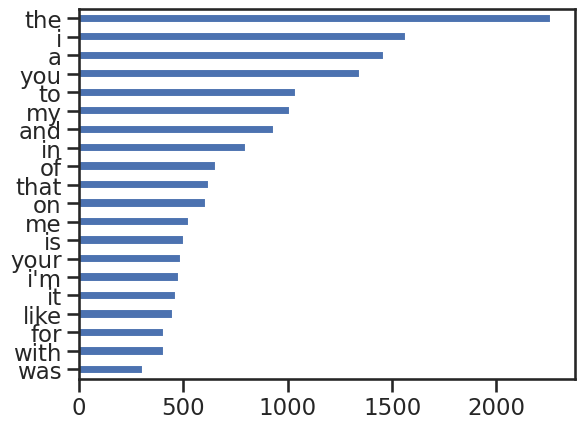

In [ ]:
# top words
pd.Series(' '.join(df.lyrics).lower().split()).value_counts()[:20][::-1].plot(kind='barh')



<Axes: >

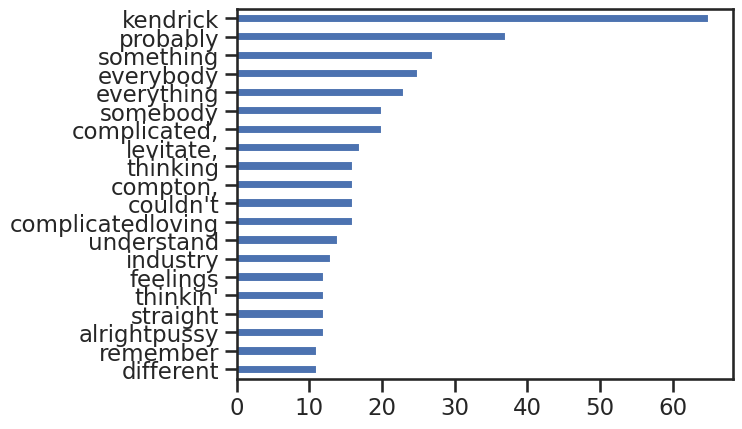

In [ ]:

# top long words
pd.Series([w for w in ' '.join(df.lyrics).lower().split() if len(w) > 7]).value_counts()[:20][::-1].plot(kind='barh')



<Axes: >

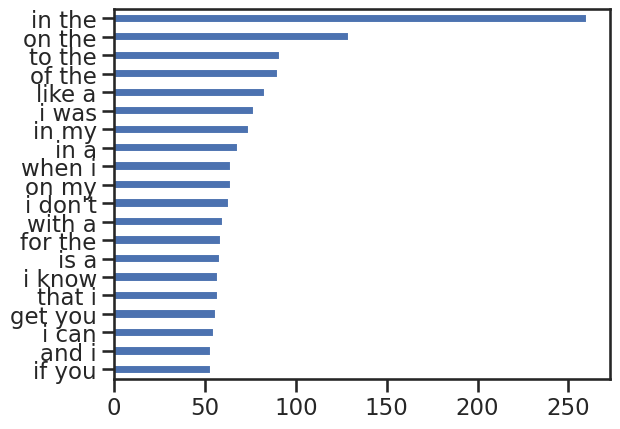

In [ ]:

from nltk import ngrams

def get_ngrams_from_series(series, n=2):
    # using nltk.ngrams
    lines = ' '.join(series).lower().split('\n')
    lgrams = [ngrams(l.split(), n) for l in lines]
    grams = [[' '.join(g) for g in list(lg)] for lg in lgrams]
    return [item for sublist in grams for item in sublist]


# Top bi-grams
pd.Series(get_ngrams_from_series(df.lyrics, 2)).value_counts()[:20][::-1].plot(kind='barh')

<Axes: >

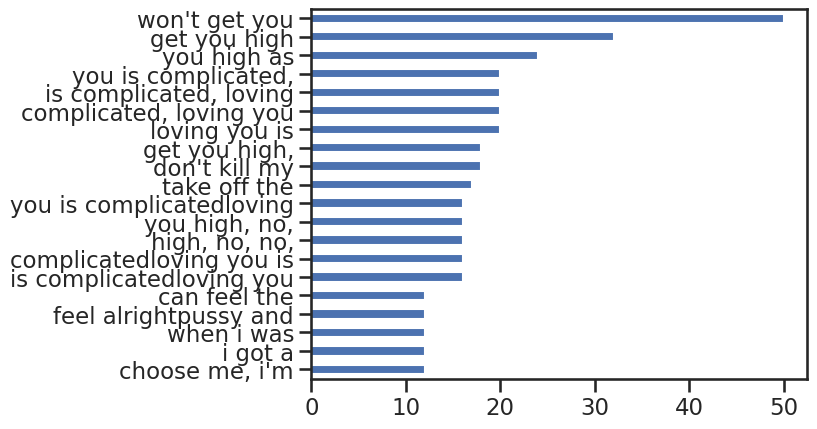

In [ ]:




# Top tri-grams
pd.Series(get_ngrams_from_series(df.lyrics, 3)).value_counts()[:20][::-1].plot(kind='barh')


<Axes: >

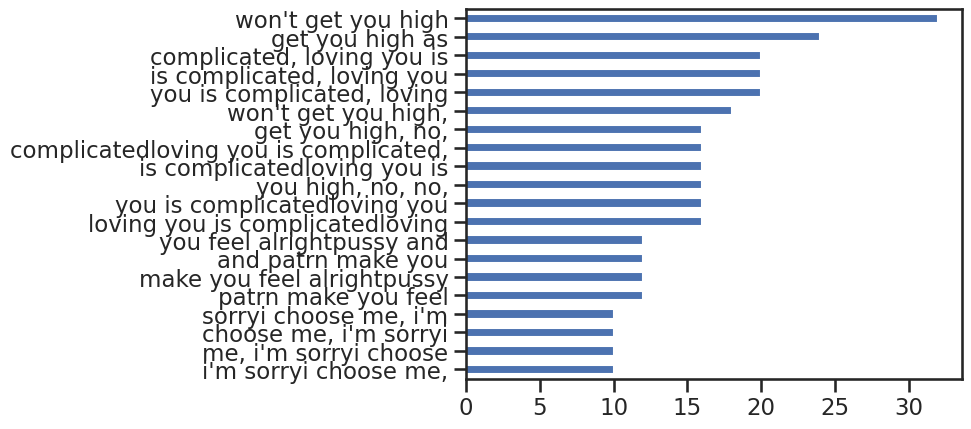

In [ ]:
# Top four-grams
pd.Series(get_ngrams_from_series(df.lyrics, 4)).value_counts()[:20][::-1].plot(kind='barh')


In [ ]:


# sentiment
import nltk
from nltk import sentiment
nltk.download('vader_lexicon')


senti_analyze = sentiment.vader.SentimentIntensityAnalyzer()


senti_analyze.polarity_scores(df.lyrics[0])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


{'neg': 0.193, 'neu': 0.721, 'pos': 0.087, 'compound': -0.9943}

array([[<Axes: title={'center': 'sentiment_score'}>]], dtype=object)

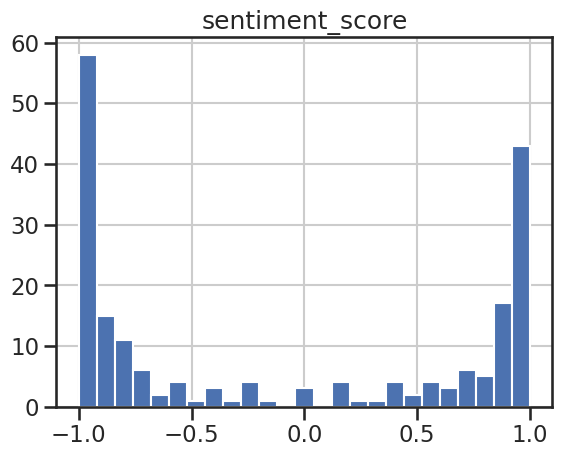

In [ ]:



df['sentiment_score'] = pd.DataFrame(df.lyrics.apply(senti_analyze.polarity_scores).tolist())['compound']
df['sentiment'] = pd.cut(df['sentiment_score'], [-np.inf, -0.35, 0.35, np.inf], labels=['negative', 'neutral', 'positive'])


# Sentiment score distribution
df[['sentiment_score']].hist(bins=25)


<ipython-input-15-83c5109d855b>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


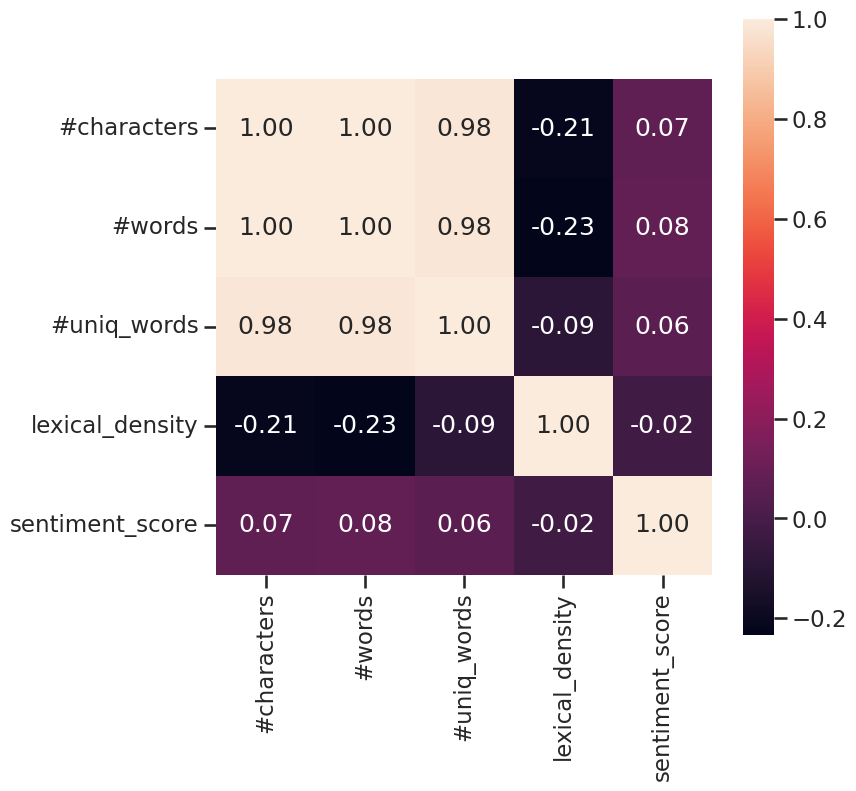

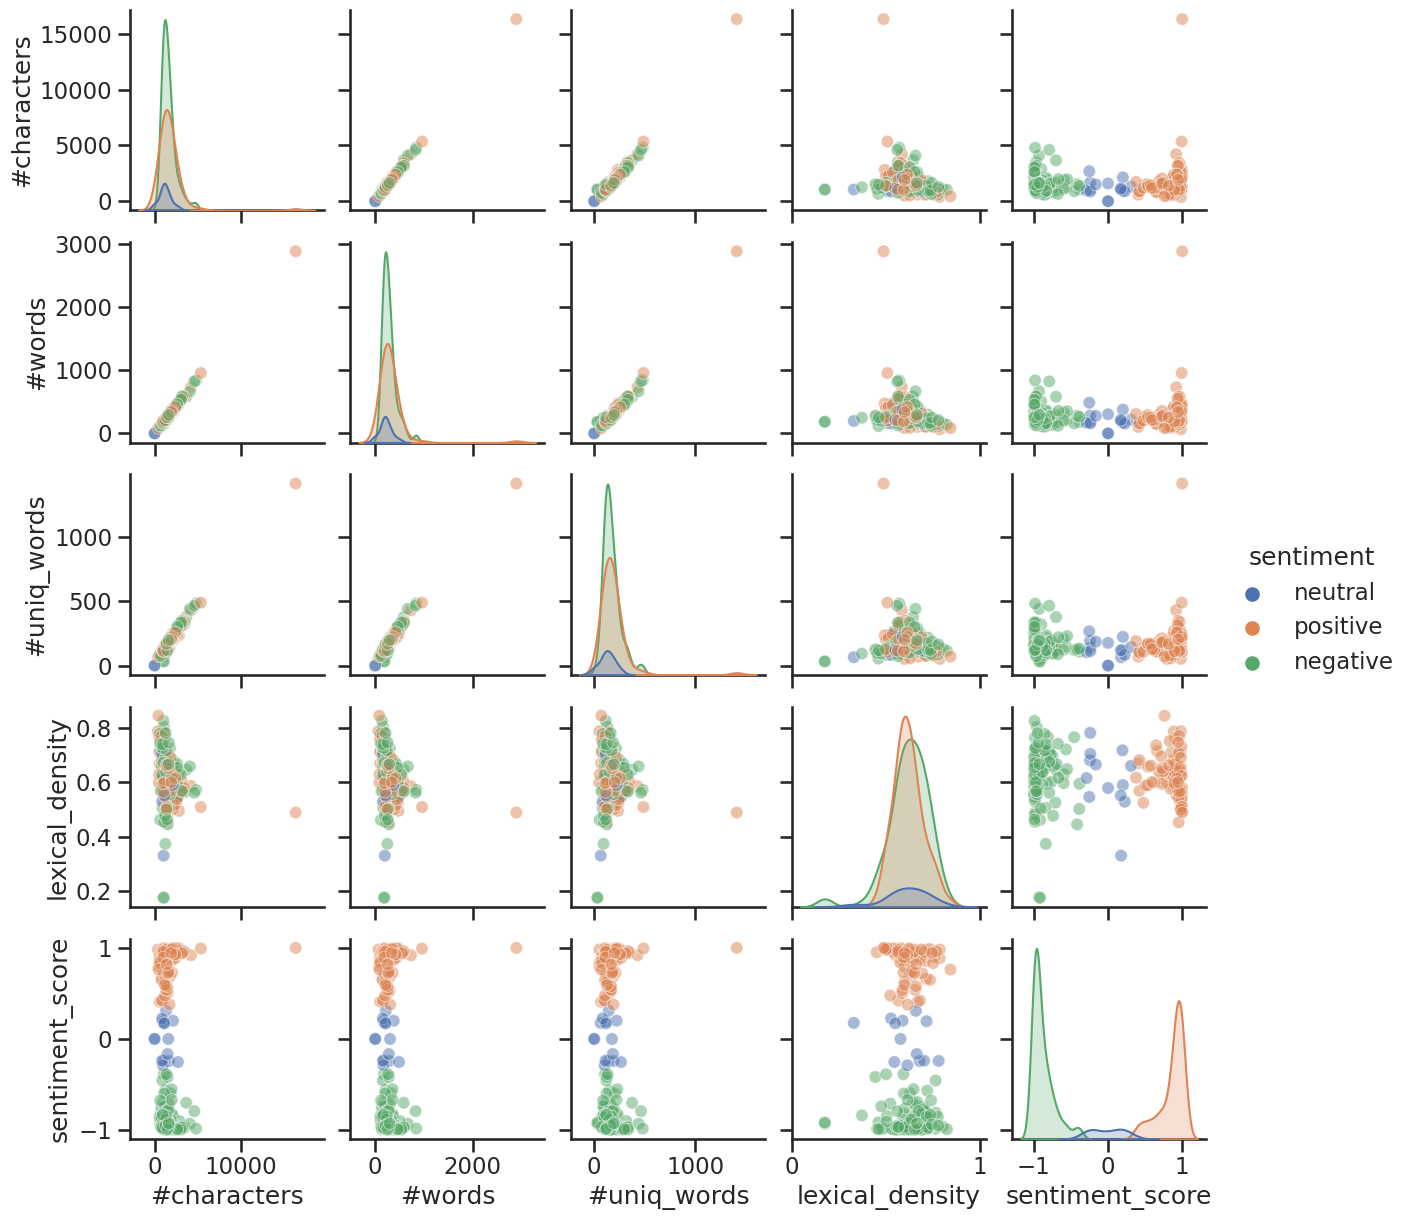

In [ ]:

corr = df.corr()
plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, fmt='.2f', square=True,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)




In [ ]:

sns.pairplot(df, hue='sentiment', hue_order=['neutral', 'positive', 'negative'], 
             plot_kws={'alpha': 0.5})

<Axes: xlabel='sentiment_score', ylabel='lexical_density'>

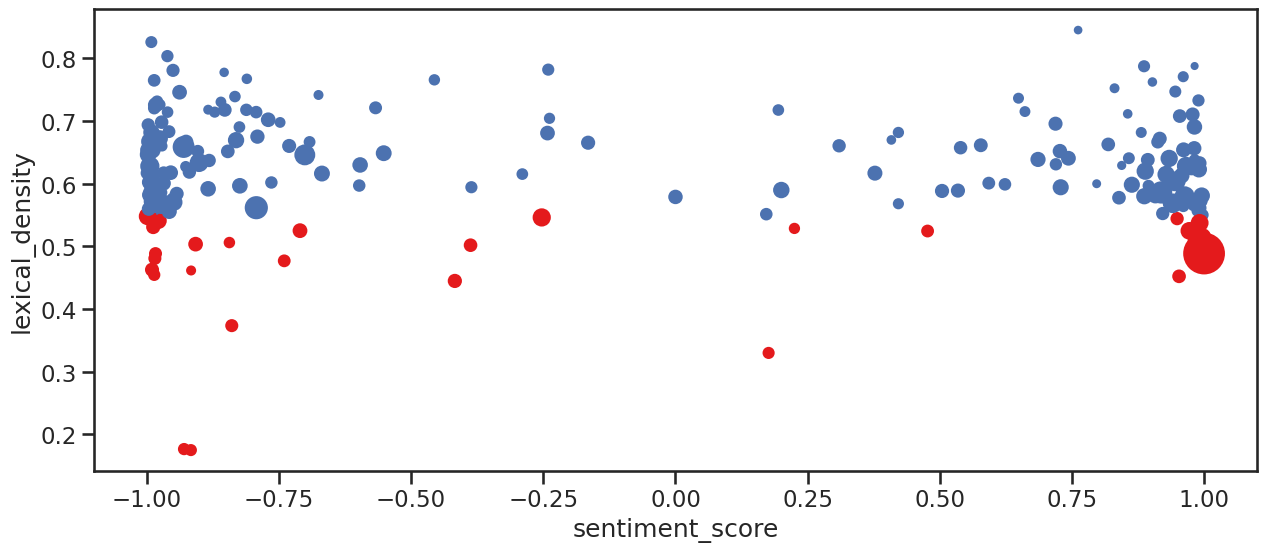

In [ ]:


# Songs with lower lexical density tend to have strong sentiments
df.plot.scatter(x='sentiment_score', y='lexical_density', s=df['#characters']/20,
                c=np.where(df['lexical_density'].le(0.55), '#e41a1c', '#4c72b0'),
                figsize=(15, 6))

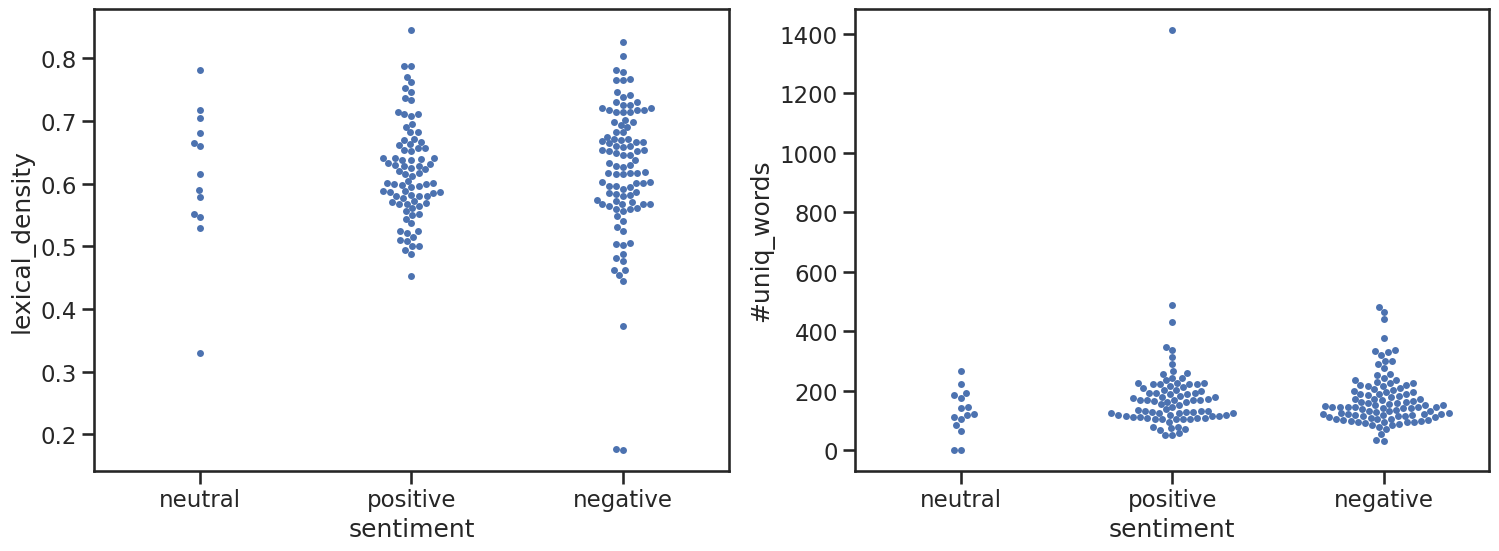

In [ ]:

# Non parametric estimates 


cols_metrics = ['lexical_density', '#uniq_words']
fig, axs = plt.subplots(figsize=(18, 6), ncols=len(cols_metrics))
for i, c in enumerate(cols_metrics):
    sns.swarmplot(x='sentiment', y=c, data=df, ax=axs[i], order=['neutral', 'positive', 'negative'])


In [ ]:

# using Markov chain

# Machine generated lyrics using Markov
import re
import random
from collections import defaultdict


class MarkovRachaita:
    def __init__(self, corpus='', order=2, length=8):
        self.order = order
        self.length = length
        self.words = re.findall("[a-z']+", corpus.lower())
        self.states = defaultdict(list)

        for i in range(len(self.words) - self.order):
            self.states[tuple(self.words[i:i + self.order])].append(self.words[i + order])

    def gen_sentence(self, length=8, startswith=None):
        terms = None
        if startswith:
            start_seed = [x for x in self.states.keys() if startswith in x]
            if start_seed:
                terms = list(start_seed[0])
        if terms is None:
            start_seed = random.randint(0, len(self.words) - self.order)
            terms = self.words[start_seed:start_seed + self.order]

        for _ in range(length):
            terms.append(random.choice(self.states[tuple(terms[-self.order:])]))

        return ' '.join(terms)

    def gen_song(self, lines=10, length=8, length_range=None, startswith=None):
        song = []
        if startswith:
            song.append(self.gen_sentence(length=length, startswith=startswith))
            lines -= 1
        for _ in range(lines):
            sent_len = random.randint(*length_range) if length_range else length
            song.append(self.gen_sentence(length=sent_len))
        return '\n'.join(song)
    
kanyai = MarkovRachaita(corpus=' '.join(df.lyrics))
kanyai.gen_song(lines=10, length_range=[5, 10])

kanyai.gen_song(lines=10, length_range=[5, 10], startswith='trump')



"dabdonald trump is a man nowi think i'm ungrateful i\ngo ahead i got the whole thingwait up\nfor these niggas approaching they mixtapes differentthey said seven\ngot aangel on his dvd for a three day run bitchtake\nbeen promotin' for 'bout a young man\nmehow many leaders gon' tell you hatingsave\nwith demons and relatives i'm a professional\ncopy off us new shit new kung fu kenny nowmy\nwhile harrassin' the corner like california kingcold hand\nlamar the peoples champion i'm animal for analystscareer damaging"

In [ ]:

# Song themes via Simplistic topic modelling
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import pandas as pd

no_topics = 5
no_features = 50
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, max_features=no_features, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(df.lyrics)
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()
nmf = NMF(n_components=no_topics, random_state=1, beta_loss='kullback-leibler', solver='mu', max_iter=1000).fit(tfidf)

def get_topics(model, feature_names, no_topwords):
    for topic_id, topic in enumerate(model.components_):
        print('topic %d:' % (topic_id))
        print(' '.join([feature_names[i] for i in topic.argsort()[:-no_topwords-1:-1]]))

s = pd.DataFrame(nmf.transform(tfidf)).idxmax(1)


In [ ]:


# NMP topics
get_topics(nmf, tfidf_feature_names, 20)



topic 0:
said like ll just im kendrick good man make cause em need time life ain right come live day bout
topic 1:
don wanna tell know love just say time look got need come right god want think bout way man day
topic 2:
feel let oh like make know cause look want live new inside life good got niggas said think ain man
topic 3:
world gon gotta yeah got way em inside ain life love like god nigga want niggas live man know come
topic 4:
nigga fuck shit bitch like niggas high won big ain black don got day ll know think need new life


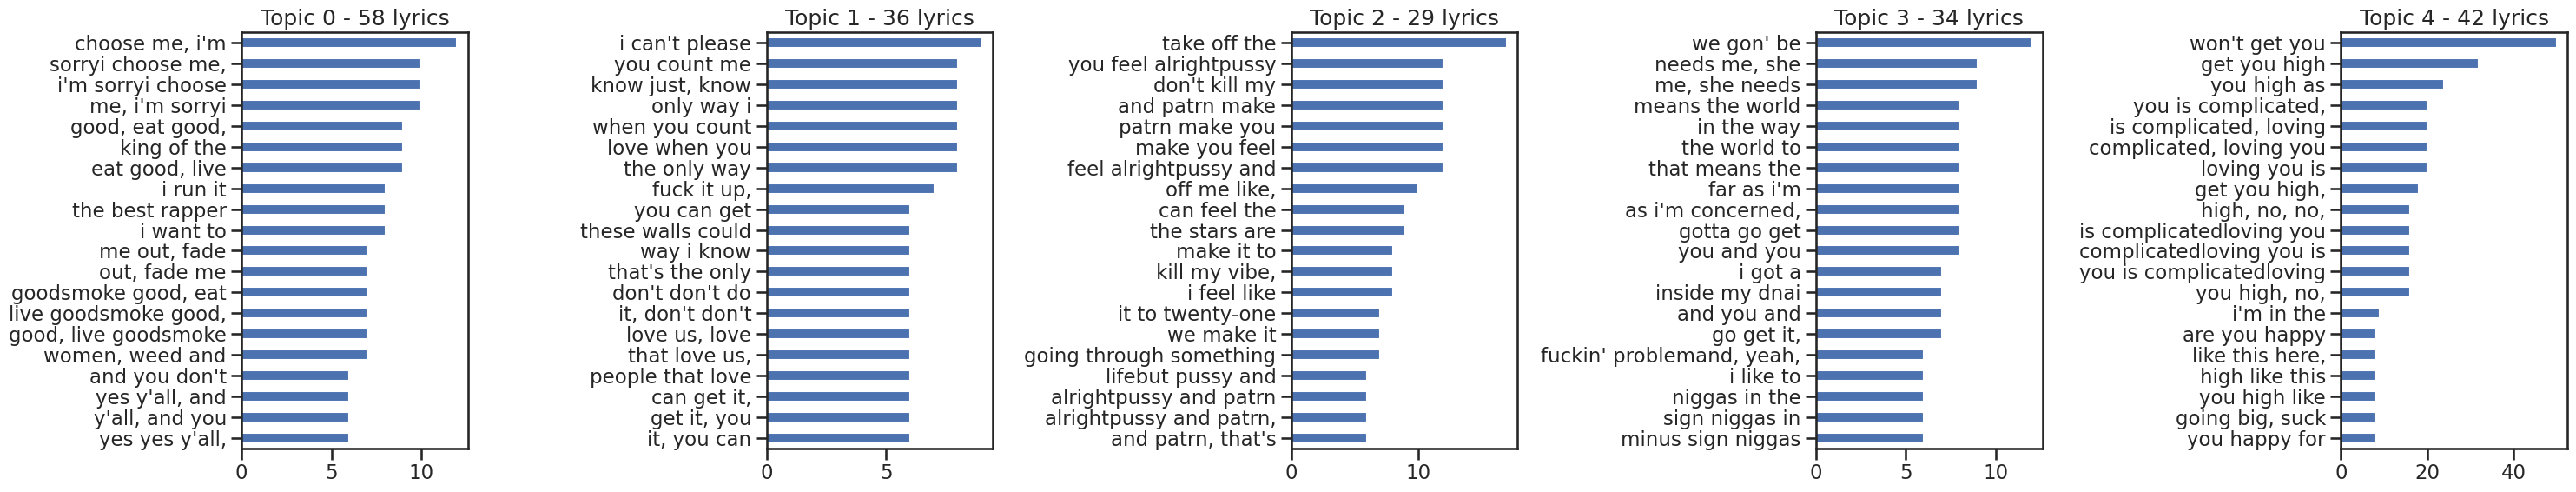

In [ ]:

# Top n-grams from the topics
topics = set(s)
fig, axs = plt.subplots(figsize=(30, 6), ncols=len(topics))
for i, v in enumerate(topics):
    dfsm = df.loc[s.eq(v), 'lyrics']
    ngram = pd.Series(get_ngrams_from_series(dfsm, 3)).value_counts()[:20][::-1]
    ngram.plot(kind='barh', ax=axs[i], title='Topic {} - {} lyrics'.format(v, s.eq(v).sum()))
plt.tight_layout()
df['topic'] = s.astype(str).radd('Topic ')


<Axes: xlabel='topic', ylabel='sentiment_score'>

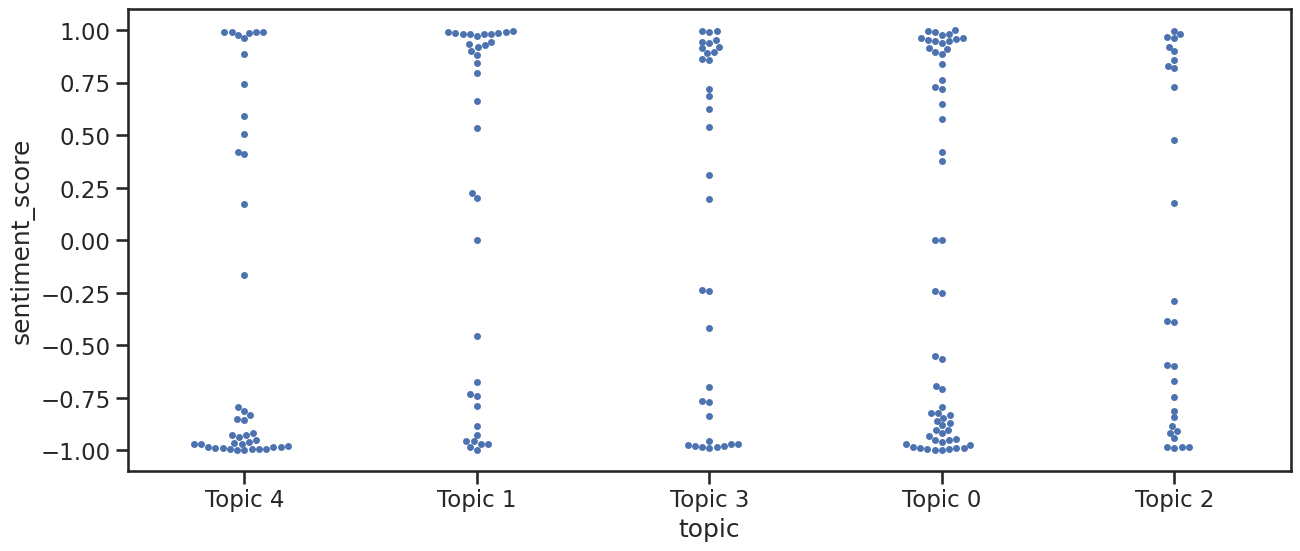

In [ ]:

# sentiment across topics

fig, axs = plt.subplots(figsize=(15, 6))
sns.swarmplot(x='topic', y='sentiment_score', data=df)


<Axes: xlabel='topic', ylabel='lexical_density'>

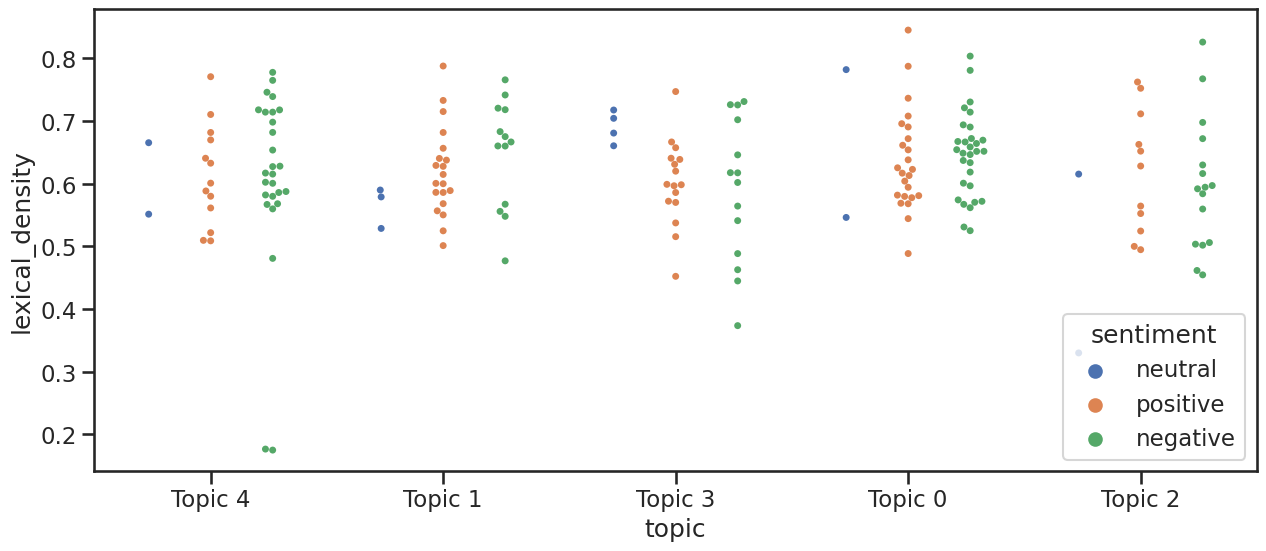

In [ ]:

# Lexical density across topics

fig, axs = plt.subplots(figsize=(15, 6))
sns.swarmplot(x='topic', y='lexical_density', hue='sentiment',
              hue_order=['neutral', 'positive', 'negative'], data=df, dodge=True)